In [43]:
from glob import glob
import sys, time, os, asyncio
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from astropy.time import Time, TimeDelta
from scipy.interpolate import UnivariateSpline

from lsst_efd_client import EfdClient, resample, merge_packed_time_series, rendezvous_dataframes
from lsst.ts.idl.enums import MTM1M3

from scipy.signal import find_peaks
from scipy.interpolate import interp1d
import astropy.units as u

In [44]:
events=pd.read_csv("../data/230628_combined_events.csv")

In [45]:
events=events.sort_values("times", ascending=False).reset_index(drop=True)

In [46]:
def link_from_date(timestamp):
    
    begin_timestamp=(Time(timestamp, format="unix") - TimeDelta(3, format='sec')).iso
    end_timestamp=(Time(timestamp, format="unix") + TimeDelta(3, format='sec')).iso
    
    begin_day=begin_timestamp[:10]
    begin_hour=begin_timestamp[11:13]
    begin_minute=begin_timestamp[14:16]
    begin_second=begin_timestamp[17:]
    
    end_day=end_timestamp[:10]
    end_hour=end_timestamp[11:13]
    end_minute=end_timestamp[14:16]
    end_second=end_timestamp[17:]
    
    url="https://summit-lsp.lsst.codes/chronograf/sources/1/dashboards/"
    url+="207?refresh=Paused&tempVars%5BDownsample%5D=Default&tempVars%5BFunction%5D="
    url+=f"raw&lower={begin_day}T{begin_hour}%3A{begin_minute}%3A{begin_second}Z"
    url+=f'&upper={end_day}T{end_hour}%3A{end_minute}%3A{end_second}Z'
    #url+=f"&zoomedLower={begin_day}T{begin_hour}%3A{begin_minute}%3A{begin_second}Z&zoomedUpper=2023-05-30T10%3A08%3A02.962Z"
    return url

In [47]:
title_str="| event number  | Time  |  elevation |  elevation velocity | hardpoint/ims dashboard  |\n|---|---|---|---|---|\n"


In [60]:
import datetime
datetime.datetime?

Init signature: datetime.datetime(self, /, *args, **kwargs)
Docstring:     
datetime(year, month, day[, hour[, minute[, second[, microsecond[,tzinfo]]]]])

The year, month and day arguments are required. tzinfo may be None, or an
instance of a tzinfo subclass. The remaining arguments may be ints.
File:           /opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-6.0.0/lib/python3.10/datetime.py
Type:           type
Subclasses:     ABCTimestamp, _NaT


In [70]:
sel.sum()

129

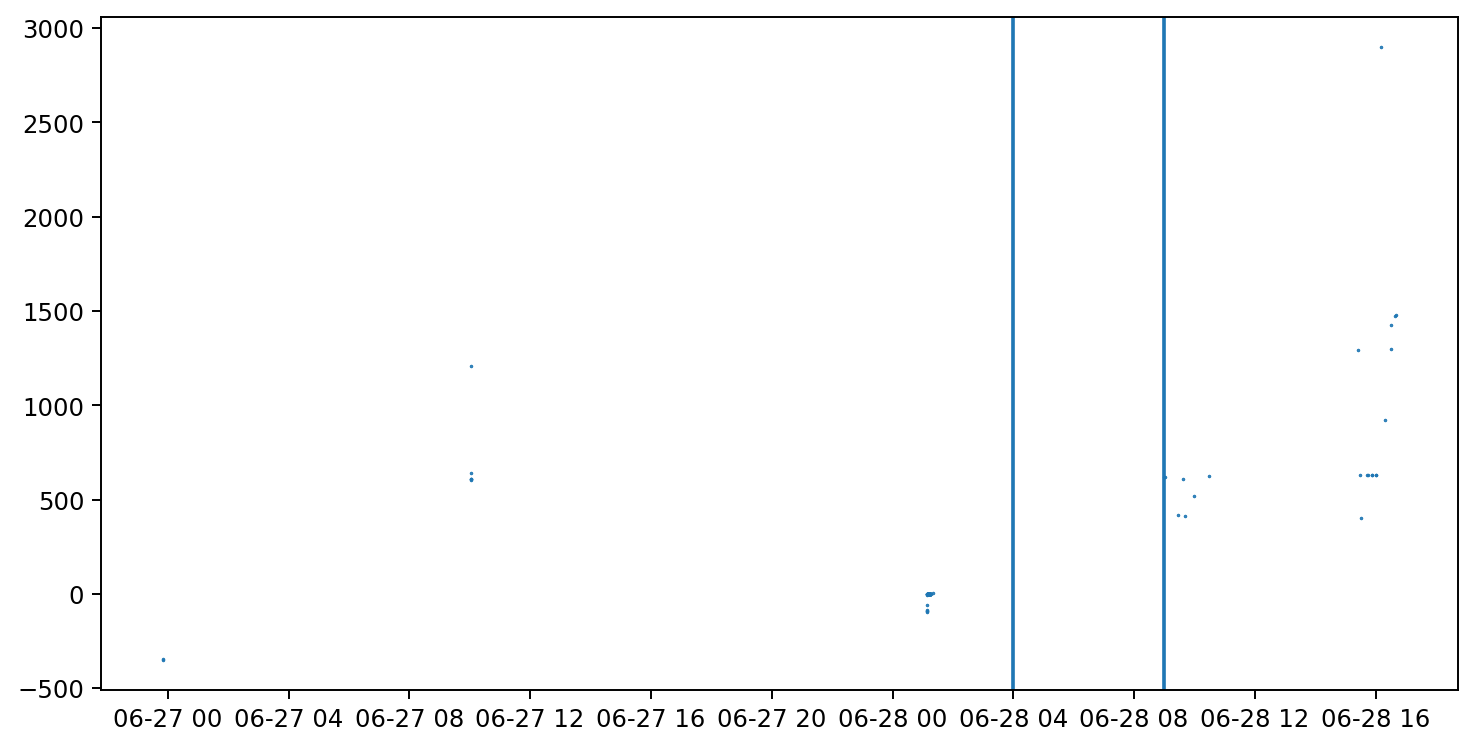

In [73]:
sel= Time(datetime.datetime(2023,6,28,4), format="datetime").unix < events["times"]
sel &= Time(datetime.datetime(2023,6,28,9), format="datetime").unix > events["times"]
plt.figure(dpi=175, figsize=(10,5))
plt.scatter(Time(events["times"][~sel], format="unix").datetime, events["rmean"][~sel], s=0.2)
plt.axvline(datetime.datetime(2023,6,28,4))
plt.axvline(datetime.datetime(2023,6,28,9))

In [76]:
row_str=""
ct=0
for j,i in enumerate((range(len(events)))):
    #if events["group"][i] < 3:
    sel= Time(datetime.datetime(2023,6,28,4), format="datetime").unix < events["times"][i]
    sel &= Time(datetime.datetime(2023,6,28,11), format="datetime").unix > events["times"][i]
    if ~sel:
        ct+=1
        row_str+=f"| {ct}  | {events['iso_time'][i]}  | "
        row_str+=f"{events['elevation_position'][i]:0.2f}  | {events['elevation_velocity'][i]:0.2f} " 
        row_str+='| <a href="'
        row_str+=f'{link_from_date(events["times"][i]-2)}'
        row_str+='" target="_blank">link to dashboard</a>|\n'

In [77]:
print(title_str+row_str)

| event number  | Time  |  elevation |  elevation velocity | hardpoint/ims dashboard  |
|---|---|---|---|---|
| 1  | 2023-06-28 16:40:26.651  | 0.21  | 0.43 | <a href="https://summit-lsp.lsst.codes/chronograf/sources/1/dashboards/207?refresh=Paused&tempVars%5BDownsample%5D=Default&tempVars%5BFunction%5D=raw&lower=2023-06-28T16%3A40%3A21.651Z&upper=2023-06-28T16%3A40%3A27.651Z" target="_blank">link to dashboard</a>|
| 2  | 2023-06-28 16:38:38.710  | 0.03  | -0.15 | <a href="https://summit-lsp.lsst.codes/chronograf/sources/1/dashboards/207?refresh=Paused&tempVars%5BDownsample%5D=Default&tempVars%5BFunction%5D=raw&lower=2023-06-28T16%3A38%3A33.710Z&upper=2023-06-28T16%3A38%3A39.710Z" target="_blank">link to dashboard</a>|
| 3  | 2023-06-28 16:31:12.206  | 30.22  | 0.44 | <a href="https://summit-lsp.lsst.codes/chronograf/sources/1/dashboards/207?refresh=Paused&tempVars%5BDownsample%5D=Default&tempVars%5BFunction%5D=raw&lower=2023-06-28T16%3A31%3A07.206Z&upper=2023-06-28T16%3A31%3A13.206Z" 